Welcome!  If you are new to Google Colab/Jupyter notebooks, you might take a look at [this notebook](https://colab.research.google.com/notebooks/basic_features_overview.ipynb) first.

**I recommend you run the first code cell of this notebook immediately, to start provisioning drake on the cloud machine, then you can leave this window open as you [read the textbook](http://underactuated.csail.mit.edu/trajopt.html).**

# Notebook Setup

The following cell will:
- on Colab (only), install Drake to `/opt/drake`, install Drake's prerequisites via `apt`, and add pydrake to `sys.path`.  This will take approximately two minutes on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  If you navigate between notebooks using Colab's "File->Open" menu, then you can avoid provisioning a separate machine for each notebook.
- import packages used throughout the notebook.

You will need to rerun this cell if you restart the kernel, but it should be fast (even on Colab) because the machine will already have drake installed.

In [1]:
import importlib
import sys
from urllib.request import urlretrieve

# Install drake (and underactuated).
if 'google.colab' in sys.modules and importlib.util.find_spec('underactuated') is None:
    urlretrieve(f"http://underactuated.csail.mit.edu/scripts/setup/setup_underactuated_colab.py",
                "setup_underactuated_colab.py")
    from setup_underactuated_colab import setup_underactuated
    setup_underactuated(underactuated_sha='560c2adace05eb20ebd78377582015d5b2d3859a', drake_version='0.27.0', drake_build='release')

# Trajectory optimization for the double integrator

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pydrake.all import eq, MathematicalProgram, Solve, Variable

# Discrete-time approximation of the double integrator.
dt = 0.01;
A = np.eye(2) + dt*np.mat('0 1; 0 0')
B = dt*np.mat('0; 1')

prog = MathematicalProgram()

N = 284  # Note: I had to do a manual "line search" to find this.

# Create decision variables
u = np.empty((1, N-1), dtype=Variable)
x = np.empty((2, N), dtype=Variable)
for n in range(N-1):
  u[:,n] = prog.NewContinuousVariables(1, 'u' + str(n))
  x[:,n] = prog.NewContinuousVariables(2, 'x' + str(n))
x[:,N-1] = prog.NewContinuousVariables(2, 'x' + str(N))

# Add constraints
x0 = [-2, 0]
prog.AddBoundingBoxConstraint(x0, x0, x[:,0])
for n in range(N-1):
  # Will eventually be prog.AddConstraint(x[:,n+1] == A@x[:,n] + B@u[:,n])
  # See drake issues 12841 and 8315
  prog.AddConstraint(eq(x[:,n+1],A.dot(x[:,n]) + B.dot(u[:,n])))
  prog.AddBoundingBoxConstraint(-1, 1, u[:,n])
xf = [0, 0]
prog.AddBoundingBoxConstraint(xf, xf, x[:, N-1])

result = Solve(prog)

x_sol = result.GetSolution(x)
assert(result.is_success()), "Optimization failed"

plt.figure()
plt.plot(x_sol[0,:], x_sol[1,:])
plt.xlabel('q')
plt.ylabel('qdot');

## Trajectory optimization using the DirectTranscription class

Because this pattern of making decision variables that are indexed over time, adding the dynamic constraints, defining the running cost and constraints, is so common, we have wrappers in drake on top of `MathematicalProgram` which handle these details for you.

The optimization below is identical to the example above, but using this helper class.

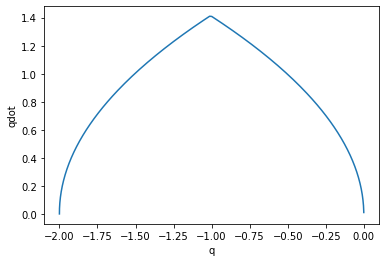

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from pydrake.all import LinearSystem, DirectTranscription

# Discrete-time approximation of the double integrator.
dt = 0.01;
A = np.eye(2) + dt*np.mat('0 1; 0 0')
B = dt*np.mat('0; 1')
C = np.eye(2)
D = np.zeros((2,1))
sys = LinearSystem(A, B, C, D, dt)

prog = DirectTranscription(sys, sys.CreateDefaultContext(), N)
prog.AddBoundingBoxConstraint(x0, x0, prog.initial_state())
prog.AddBoundingBoxConstraint(xf, xf, prog.final_state())
prog.AddConstraintToAllKnotPoints(prog.input()[0] <= 1)
prog.AddConstraintToAllKnotPoints(prog.input()[0] >= -1)

result = Solve(prog)
x_sol = prog.ReconstructStateTrajectory(result)
assert(result.is_success()), "Optimization failed"

plt.figure()
x_values = x_sol.vector_values(x_sol.get_segment_times())

plt.plot(x_values[0,:], x_values[1,:])
plt.xlabel('q')
plt.ylabel('qdot');

One thing that I'm very proud of (it was a lot of work!) is the fact that drake is often smart enough to introspect your system, costs, and constraints and understand whether you have formulated a convex problem or a non-convex one.  The optimization above calls a convex optimization solver.  But if you had passed in a nonlinear system instead, it would have switched to calling a solver that supports nonlinear programming.

# Direct Collocation for the Pendulum

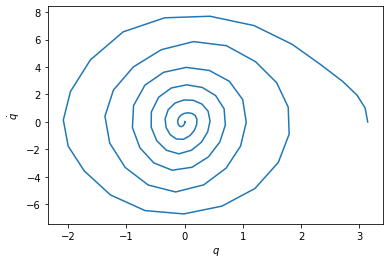

In [4]:
import math
import numpy as np

import matplotlib.pyplot as plt

from pydrake.examples.pendulum import PendulumPlant, PendulumState
from pydrake.all import DirectCollocation, PiecewisePolynomial, Solve
from underactuated.pendulum import PendulumVisualizer


plant = PendulumPlant()
context = plant.CreateDefaultContext()

N = 21
max_dt = 0.5
max_tf = N * max_dt
dircol = DirectCollocation(plant,
                           context,
                           num_time_samples=N,
                           minimum_timestep=0.05,
                           maximum_timestep=max_dt)

dircol.AddEqualTimeIntervalsConstraints()

torque_limit = 3.0  # N*m.
u = dircol.input()
dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[0])
dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)

initial_state = PendulumState()
initial_state.set_theta(0.0)
initial_state.set_thetadot(0.0)
dircol.AddBoundingBoxConstraint(initial_state.get_value(),
                                initial_state.get_value(),
                                dircol.initial_state())
# More elegant version is blocked on drake #8315:
# dircol.AddLinearConstraint(
#     dircol.initial_state() == initial_state.get_value())

final_state = PendulumState()
final_state.set_theta(math.pi)
final_state.set_thetadot(0.0)
dircol.AddBoundingBoxConstraint(final_state.get_value(),
                                final_state.get_value(), dircol.final_state())
# dircol.AddLinearConstraint(dircol.final_state() == final_state.get_value())

R = 10  # Cost on input "effort".
dircol.AddRunningCost(R * u[0]**2)

initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
    [0., 4.], [initial_state.get_value(),
               final_state.get_value()])
dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

result = Solve(dircol)
assert result.is_success()

x_trajectory = dircol.ReconstructStateTrajectory(result)

fig, ax = plt.subplots()

x_knots = np.hstack([
    x_trajectory.value(t) for t in np.linspace(x_trajectory.start_time(),
                                               x_trajectory.end_time(), 100)
])

ax.set_xlabel('$q$')
ax.set_ylabel('$\dot{q}$')
ax.plot(x_knots[0, :], x_knots[1, :]);

In [5]:
from IPython.display import HTML

# Animate the result.
vis = PendulumVisualizer(show=False)
ani = vis.animate(x_trajectory)
HTML(ani.to_jshtml())

# Direct Collocation for the Acrobot

Almost identical code works to swing-up the Acrobot.

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

from pydrake.all import (DirectCollocation, DiagramBuilder, PiecewisePolynomial,
                         PlanarSceneGraphVisualizer, SceneGraph, Simulator,
                         Solve, TrajectorySource)
from pydrake.examples.acrobot import AcrobotGeometry, AcrobotPlant
from underactuated import FindResource

plant = AcrobotPlant()
context = plant.CreateDefaultContext()

dircol = DirectCollocation(plant,
                           context,
                           num_time_samples=21,
                           minimum_timestep=0.05,
                           maximum_timestep=0.2)

dircol.AddEqualTimeIntervalsConstraints()

# Add input limits.
torque_limit = 8.0  # N*m.
u = dircol.input()
dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[0])
dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)

initial_state = (0., 0., 0., 0.)
dircol.AddBoundingBoxConstraint(initial_state, initial_state,
                                dircol.initial_state())
# More elegant version is blocked on drake #8315:
# dircol.AddLinearConstraint(dircol.initial_state() == initial_state)

final_state = (math.pi, 0., 0., 0.)
dircol.AddBoundingBoxConstraint(final_state, final_state, dircol.final_state())
# dircol.AddLinearConstraint(dircol.final_state() == final_state)

R = 10  # Cost on input "effort".
dircol.AddRunningCost(R * u[0]**2)

# Add a final cost equal to the total duration.
dircol.AddFinalCost(dircol.time())

initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
    [0., 4.], np.column_stack((initial_state, final_state)))  # yapf: disable
dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

result = Solve(dircol)
assert (result.is_success())

u_trajectory = dircol.ReconstructInputTrajectory(result)
times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
u_lookup = np.vectorize(u_trajectory.value)
u_values = u_lookup(times)

plt.figure()
plt.plot(times, u_values)
plt.xlabel("time (seconds)")
plt.ylabel("force (Newtons)");

In [8]:
u_values

array([-8.        , -8.        , -8.        , -8.        , -8.        ,
       -8.        , -8.        , -8.        , -8.        , -8.        ,
       -7.88371379, -6.72085166, -5.55798954, -4.39512742, -3.23226529,
       -1.93341332,  0.13604779,  2.2055089 ,  4.27497   ,  6.34443111,
        7.85414831,  7.12488983,  6.39563136,  5.66637288,  4.93711441,
        3.76440437,  1.26133961, -1.24172515, -3.74478991, -6.24785467,
       -8.        , -8.        , -8.        , -8.        , -8.        ,
       -8.        , -8.        , -8.        , -8.        , -8.        ,
       -8.        , -8.        , -8.        , -8.        , -8.        ,
       -6.83082229, -4.23264961, -1.63447693,  0.96369575,  3.56186843,
        5.17803005,  5.8121806 ,  6.44633115,  7.0804817 ,  7.71463225,
        8.        ,  8.        ,  8.        ,  8.        ,  8.        ,
        8.        ,  8.        ,  8.        ,  8.        ,  8.        ,
        8.        ,  8.        ,  8.        ,  8.        ,  8.  

<IPython.core.display.Javascript object>


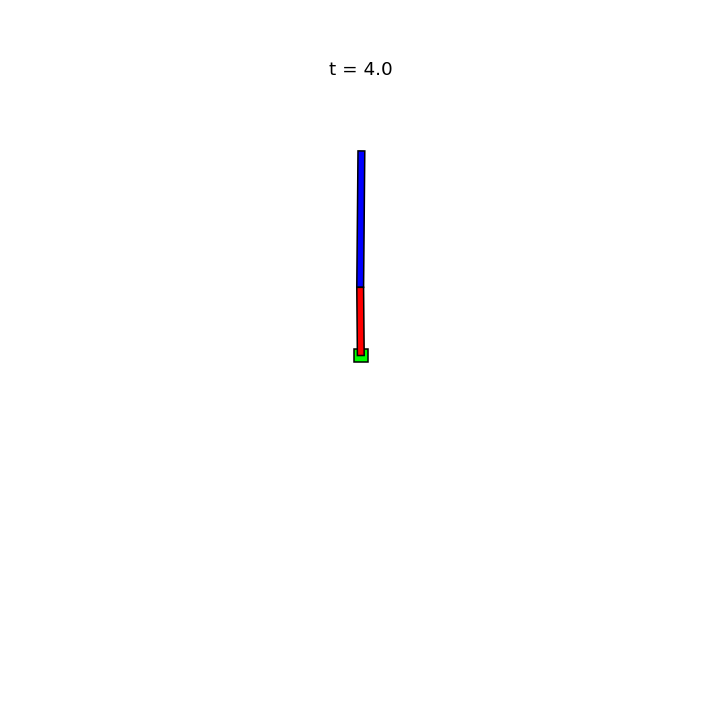

In [7]:
from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend
plt_is_interactive = SetupMatplotlibBackend()

x_trajectory = dircol.ReconstructStateTrajectory(result)

builder = DiagramBuilder()
source = builder.AddSystem(TrajectorySource(x_trajectory))
scene_graph = builder.AddSystem(SceneGraph())
AcrobotGeometry.AddToBuilder(builder, source.get_output_port(0), scene_graph)
visualizer = builder.AddSystem(
    PlanarSceneGraphVisualizer(scene_graph, xlim=[-4., 4.], ylim=[-4., 4.],
                               show=plt_is_interactive))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
                visualizer.get_input_port(0))
simulator = Simulator(builder.Build())

# Simulate and animate
AdvanceToAndVisualize(simulator, visualizer, x_trajectory.end_time())

## Trajectory stabilization with (finite-horizon) LQR

The visualization above was an animation of the solution trajectory, it was not a simulation!  In fact, if you simulate only the planned torques connected to the Acrobot, then you will see that the trajectory does not follow the planned state trajectory.  The trajectory optimization only satisfies the dynamic constraints to some loose tolerance, and the (open-loop) trajectory is unstable.

To do better, we must stabilizing the planned trajectory with feedback.  We do that here with a finite-horizon LQR design, which takes a time-varying linearization of the plant along the trajectory.

<IPython.core.display.Javascript object>


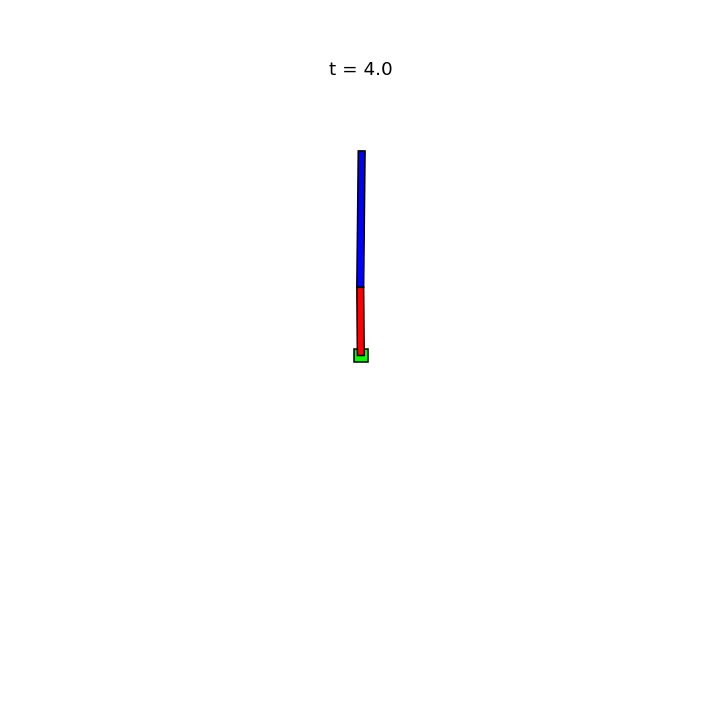

<IPython.core.display.Javascript object>


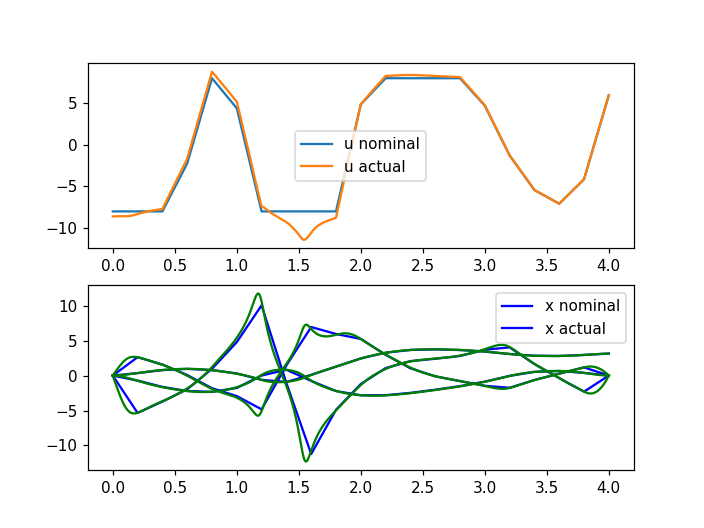

In [8]:
from pydrake.all import MakeFiniteHorizonLinearQuadraticRegulator, FiniteHorizonLinearQuadraticRegulatorOptions, LogOutput

options = FiniteHorizonLinearQuadraticRegulatorOptions()
options.x0 = dircol.ReconstructStateTrajectory(result)
options.u0 = dircol.ReconstructInputTrajectory(result)

builder = DiagramBuilder()
plant = builder.AddSystem(AcrobotPlant())
context = plant.CreateDefaultContext()
Q = np.diag([10.,10.,1.,1.])
options.Qf = Q
regulator = builder.AddSystem(MakeFiniteHorizonLinearQuadraticRegulator(
  plant, context, t0=options.u0.start_time(),
  tf=options.u0.end_time(), Q=Q, R=np.eye(1),
  options=options))
builder.Connect(regulator.get_output_port(0), plant.get_input_port(0))
builder.Connect(plant.get_output_port(0), regulator.get_input_port(0))
input_logger = LogOutput(regulator.get_output_port(0), builder)
state_logger = LogOutput(plant.get_output_port(0), builder)

scene_graph = builder.AddSystem(SceneGraph())
AcrobotGeometry.AddToBuilder(builder, plant.get_output_port(0), scene_graph)
visualizer = builder.AddSystem(
    PlanarSceneGraphVisualizer(scene_graph, xlim=[-4., 4.], ylim=[-4., 4.],
                               show=plt_is_interactive))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
                visualizer.get_input_port(0))
diagram = builder.Build()
simulator = Simulator(diagram)

# Simulate and animate
AdvanceToAndVisualize(simulator, visualizer, options.u0.end_time())

fig, ax = plt.subplots(2,1)
ax[0].plot(options.u0.get_segment_times(), options.u0.vector_values(options.u0.get_segment_times()).T)
ax[0].plot(input_logger.sample_times(), input_logger.data().T)
ax[0].legend(('u nominal','u actual'))

ax[1].plot(options.x0.get_segment_times(), options.x0.vector_values(options.x0.get_segment_times()).T, 'b')
ax[1].plot(state_logger.sample_times(), state_logger.data().T, 'g')
ax[1].legend(('x nominal','x actual'));


# Direct Collocation for the Cart-Pole

While the previous two examples used equations of motion that we derived and typed in manually, for the Cart-Pole we will use the Drake dynamics engine and visualization via [`MultibodyPlant`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_multibody_plant.html) and [`SceneGraph`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1geometry_1_1_scene_graph.html).

<IPython.core.display.Javascript object>


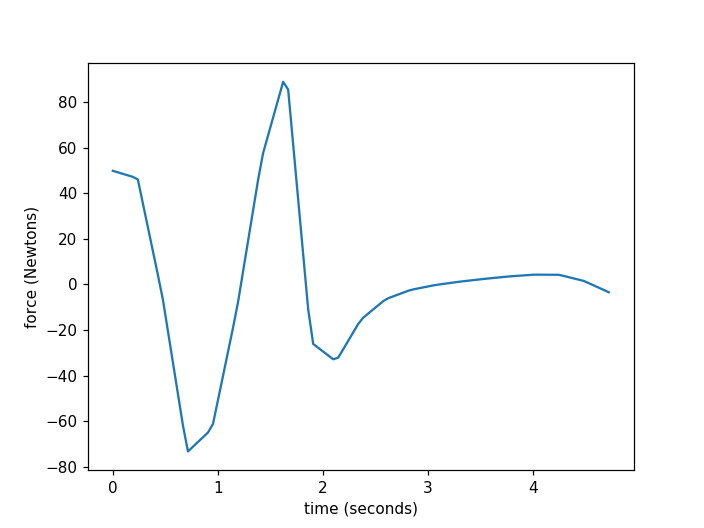

In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt

from pydrake.all import (DiagramBuilder, DirectCollocation, MultibodyPlant,
                         MultibodyPositionToGeometryPose, Parser,
                         PiecewisePolynomial, PlanarSceneGraphVisualizer,
                         SceneGraph, Simulator, Solve, TrajectorySource)
from underactuated import FindResource

plant = MultibodyPlant(time_step=0.0)
scene_graph = SceneGraph()
plant.RegisterAsSourceForSceneGraph(scene_graph)
file_name = FindResource("models/cartpole.urdf")
Parser(plant).AddModelFromFile(file_name)
plant.Finalize()

context = plant.CreateDefaultContext()
dircol = DirectCollocation(
    plant,
    context,
    num_time_samples=21,
    minimum_timestep=0.1,
    maximum_timestep=0.4,
    input_port_index=plant.get_actuation_input_port().get_index())

dircol.AddEqualTimeIntervalsConstraints()

initial_state = (0., 0., 0., 0.)
dircol.AddBoundingBoxConstraint(initial_state, initial_state,
                                dircol.initial_state())
# More elegant version is blocked by drake #8315:
# dircol.AddLinearConstraint(dircol.initial_state() == initial_state)

final_state = (0., math.pi, 0., 0.)
dircol.AddBoundingBoxConstraint(final_state, final_state, dircol.final_state())
# dircol.AddLinearConstraint(dircol.final_state() == final_state)

R = 10  # Cost on input "effort".
u = dircol.input()
dircol.AddRunningCost(R * u[0]**2)

# Add a final cost equal to the total duration.
dircol.AddFinalCost(dircol.time())

initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
    [0., 4.], np.column_stack((initial_state, final_state)))  # yapf: disable
dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

result = Solve(dircol)
assert result.is_success()

fig, ax = plt.subplots()

u_trajectory = dircol.ReconstructInputTrajectory(result)
times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
u_lookup = np.vectorize(u_trajectory.value)
u_values = u_lookup(times)

ax.plot(times, u_values)
ax.set_xlabel("time (seconds)")
ax.set_ylabel("force (Newtons)");

<IPython.core.display.Javascript object>


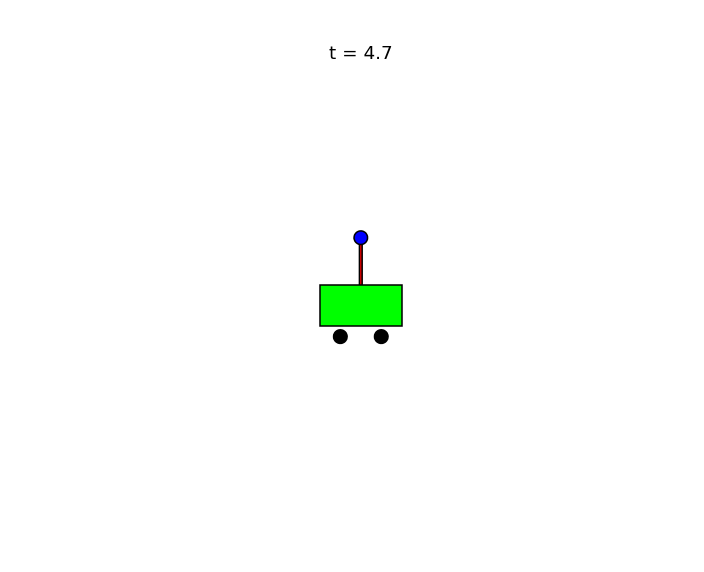

In [10]:
# Animate the results.
from IPython.display import HTML
from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend
plt_is_interactive = SetupMatplotlibBackend()

x_trajectory = dircol.ReconstructStateTrajectory(result)

# TODO(russt): Add some helper methods to make this workflow cleaner.
builder = DiagramBuilder()
source = builder.AddSystem(TrajectorySource(x_trajectory))
builder.AddSystem(scene_graph)
pos_to_pose = builder.AddSystem(
    MultibodyPositionToGeometryPose(plant, input_multibody_state=True))
builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
builder.Connect(pos_to_pose.get_output_port(),
                scene_graph.get_source_pose_port(plant.get_source_id()))

visualizer = builder.AddSystem(
    PlanarSceneGraphVisualizer(scene_graph,
                               xlim=[-2, 2],
                               ylim=[-1.25, 2],
                               show=plt_is_interactive))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
                visualizer.get_input_port(0))
simulator = Simulator(builder.Build())

AdvanceToAndVisualize(simulator, visualizer, x_trajectory.end_time())

# Trajectory optimization using mixed-integer quadratic programming (MIQP)

In [11]:
from ipywidgets import interact
import numpy as np
import meshcat
import meshcat.geometry as g
import meshcat.transformations as tf
from pydrake.all import (MathematicalProgram, Solve, eq, le, ge,
    MixedIntegerBranchAndBound, OsqpSolver, GurobiSolver)
import sys
from underactuated.meshcat_utils import set_planar_viewpoint, draw_points

# Start a meshcat server instance (if needed).
if 'zmq_url' not in locals():
  server_args = []
  if 'google.colab' in sys.modules:
    server_args = ['--ngrok_http_tunnel']
  from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
  proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

prog = MathematicalProgram()

lp_relaxation = False
N = 20     # number of timesteps
h = 0.1    # timestep
bigM = 10
q_start = np.array([0., -2.])
q_goal = np.array([0., 2.])

q = prog.NewContinuousVariables(2, N, "q")   # positions
v = prog.NewContinuousVariables(2, N, "v")   # velocities
u = prog.NewContinuousVariables(2, N-1, "u") # acceleration command
if lp_relaxation:
  b = prog.NewContinuousVariables(4, N-1, "b") # binaries for collisions
  prog.AddBoundingBoxConstraint(0, 1, b)
else:
  b = prog.NewBinaryVariables(4, N-1, "b")     # binaries for collisions

# Initial value constraint:
start = prog.AddLinearConstraint(eq(q[:,0], q_start))
prog.AddLinearConstraint(eq(v[:,0], [0., 0.]))

# Final value constraint:
goal = prog.AddLinearConstraint(eq(q[:,N-1], q_goal))
prog.AddLinearConstraint(eq(v[:,N-1], [0., 0.]))

for n in range(0, N-1):
  # Dynamics constraints:
  prog.AddLinearConstraint(eq(q[:,n+1], q[:,n] + h*v[:,n]))
  prog.AddLinearConstraint(eq(v[:,n+1], v[:,n] + h*u[:,n]))

  # Stage cost: sum u^2
  prog.AddQuadraticCost(u[:,n].dot(u[:,n]))

  # Collision avoidance constraints:
  prog.AddLinearConstraint(q[0,n+1] >= 1 - (1-b[0,n])*bigM)
  prog.AddLinearConstraint(q[0,n+1] <= -1 + (1-b[1,n])*bigM)
  prog.AddLinearConstraint(q[1,n+1] >= 1 - (1-b[2,n])*bigM)
  prog.AddLinearConstraint(q[1,n+1] <= -1 + (1-b[3,n])*bigM)
  prog.AddLinearConstraint(np.sum(b[:,n]) >= 1)

vis = meshcat.Visualizer(zmq_url=zmq_url, server_args=server_args)
vis.delete()
vis["obstacle"].set_object(g.Box([2, 2, 2]), g.MeshLambertMaterial(color=0xdd0000))
# fyi: PointsGeometry (via e.g. draw_points) weren't visible in the orthographic
# projection (despite looking fine in 3d).
# draw_points(vis["start_pt"], points=[start_x, 0, start_y], color=[0., 0., .9], size=0.1)
vis["start_pt"].set_object(g.Sphere(.05), g.MeshLambertMaterial(color=0x0000dd))
vis["goal_pt"].set_object(g.Sphere(.05), g.MeshLambertMaterial(color=0x00dd00))
set_planar_viewpoint(vis, xmin=-4, xmax=4, ymin=-4, ymax=4)

# TODO(russt): Get this working with MixedIntegerBranchAndBound
# TODO(russt): Change this to just Solve(prog) below. See drake #13299
solver = GurobiSolver()
#solver = MixedIntegerBranchAndBound(prog, GurobiSolver().solver_id())
#solver = MixedIntegerBranchAndBound(prog, OsqpSolver().solver_id())

def solve(start_x, start_y, goal_x, goal_y):
  start.evaluator().UpdateLowerBound([start_x, start_y])
  start.evaluator().UpdateUpperBound([start_x, start_y])
  goal.evaluator().UpdateLowerBound([goal_x, goal_y])
  goal.evaluator().UpdateUpperBound([goal_x, goal_y])

  result = solver.Solve(prog)
  #result = solver.Solve()
  print('Feasible: ' + str(result.is_success()))

  qt = result.GetSolution(q)
  bt = result.GetSolution(b)

  vertices = np.vstack([qt[0,:],0*qt[0,:],qt[1,:]])
  vis["qt"].set_object(g.Line(
      g.PointsGeometry(vertices),
      g.LineBasicMaterial(color=0x000000)))

  vis["start_pt"].set_transform(tf.translation_matrix([start_x, 0, start_y]))
  vis["goal_pt"].set_transform(tf.translation_matrix([goal_x, 0, goal_y]))
  # TODO: draw binaries on the plot?  (how?)

if not solver.available():
    print("This example doesn't work on the open-source solvers yet.  Coming soon!")
else:
    interact(solve, start_x=(-4,4,0.1), start_y=(-4,-1,0.1), goal_x=(-4,4,0.1), goal_y=(0,4,0.1));

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/
This example doesn't work on the open-source solvers yet.  Coming soon!
